<a href="https://colab.research.google.com/github/VinceVence/aquaponics-handbook/blob/main/Fish_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish Classification using transfer learning

## Import Necessary Libraries

In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [ ]:
# Tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model


In [ ]:
# Metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

## Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-05-08 08:56:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-05-08 08:56:17 (14.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Load and transform Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
unzip_data("/content/drive/MyDrive/Software Engineering 2/Tentative Datasets/Fish_Classification.zip")

### Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path('/content/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [ ]:
image_df.Label.nunique()

9

In [ ]:
walk_through_dir(image_dir)

There are 9 directories and 3 images in '/content/Fish_Dataset/Fish_Dataset'.
There are 2 directories and 0 images in '/content/Fish_Dataset/Fish_Dataset/Red Sea Bream'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream GT'.
There are 2 directories and 0 images in '/content/Fish_Dataset/Fish_Dataset/Sea Bass'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass GT'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass'.
There are 2 directories and 0 images in '/content/Fish_Dataset/Fish_Dataset/Red Mullet'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet'.
There are 0 directories and 1000 images in '/content/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet GT'.
There are 2 directories

In [ ]:
labels

0          Red Sea Bream
1          Red Sea Bream
2          Red Sea Bream
3          Red Sea Bream
4          Red Sea Bream
              ...       
17995    Hourse Mackerel
17996    Hourse Mackerel
17997    Hourse Mackerel
17998    Hourse Mackerel
17999    Hourse Mackerel
Name: Label, Length: 18000, dtype: object

In [ ]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

,Filepath,Label
0,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet
1,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp
2,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
3,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
4,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet


### Visualizing images from the dataset

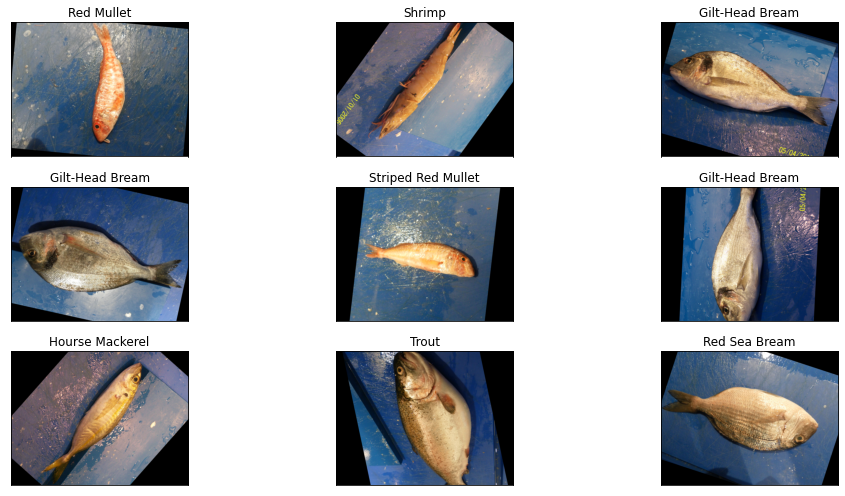

In [ ]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

## Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


## Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 50

**Input Shape** : (224, 224, 3)

**Output layer** : 9



In [ ]:
# Load the pretained model
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


### Setting up Callbacks

In [ ]:
# Create checkpoint callback
checkpoint_path = "fish_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

### Summary of the CNN model architecture
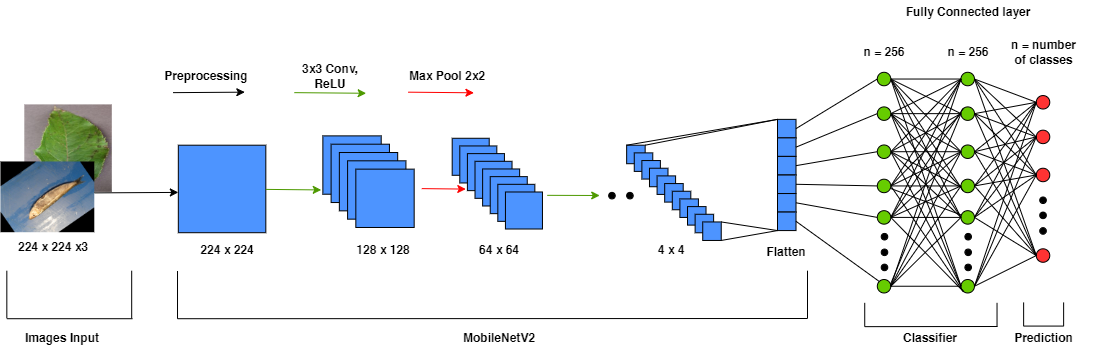

In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fish_classification_tensorboard"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fish_classification_tensorboard/20220508-085736
Epoch 1/50
180/180 [==============================] - 101s 486ms/step - loss: 0.1599 - accuracy: 0.9507 - val_loss: 0.0217 - val_accuracy: 0.9931
Epoch 2/50
180/180 [==============================] - 70s 391ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0236 - val_accuracy: 0.9910
Epoch 3/50
180/180 [==============================] - 69s 384ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0104 - val_accuracy: 0.9986
Epoch 4/50
180/180 [==============================] - 69s 384ms/step - loss: 8.7140e-04 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9986
Epoch 5/50
180/180 [==============================] - 69s 382ms/step - loss: 4.0341e-04 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9986
Epoch 6/50
180/180 [==============================] - 69s 383ms/step - loss: 2.7569e-04 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9979


### Visualizing the model architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



### Visualizing loss curves

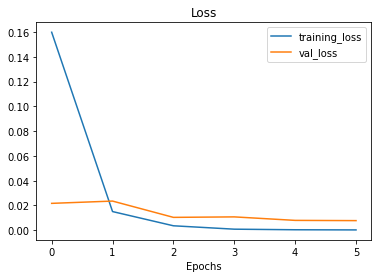

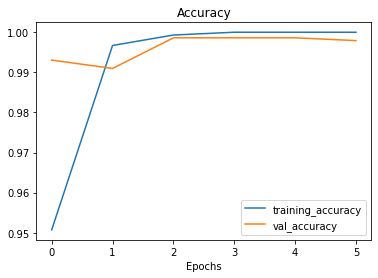

In [ ]:
plot_loss_curves(history)

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00722
Test Accuracy: 99.78%


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Black Sea Sprat', 'Black Sea Sprat', 'Black Sea Sprat', 'Hourse Mackerel', 'Striped Red Mullet']


## Evaluate Model

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       206
   Gilt-Head Bream       0.99      0.99      0.99       188
   Hourse Mackerel       1.00      1.00      1.00       202
        Red Mullet       1.00      0.99      1.00       187
     Red Sea Bream       0.99      1.00      1.00       196
          Sea Bass       1.00      1.00      1.00       225
            Shrimp       1.00      1.00      1.00       208
Striped Red Mullet       0.99      0.99      0.99       183
             Trout       1.00      1.00      1.00       205

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Black Sea Sprat,0.995169,1.000000,0.997579,206.000000
Gilt-Head Bream,0.994681,0.994681,0.994681,188.000000
Hourse Mackerel,1.000000,1.000000,1.000000,202.000000
Red Mullet,1.000000,0.994652,0.997319,187.000000
Red Sea Bream,0.994924,1.000000,0.997455,196.000000
Sea Bass,1.000000,0.995556,0.997773,225.000000
Shrimp,1.000000,1.000000,1.000000,208.000000
Striped Red Mullet,0.994536,0.994536,0.994536,183.000000
Trout,1.000000,1.000000,1.000000,205.000000
accuracy,0.997778,0.997778,0.997778,0.997778


In [ ]:
list(labels.values())

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

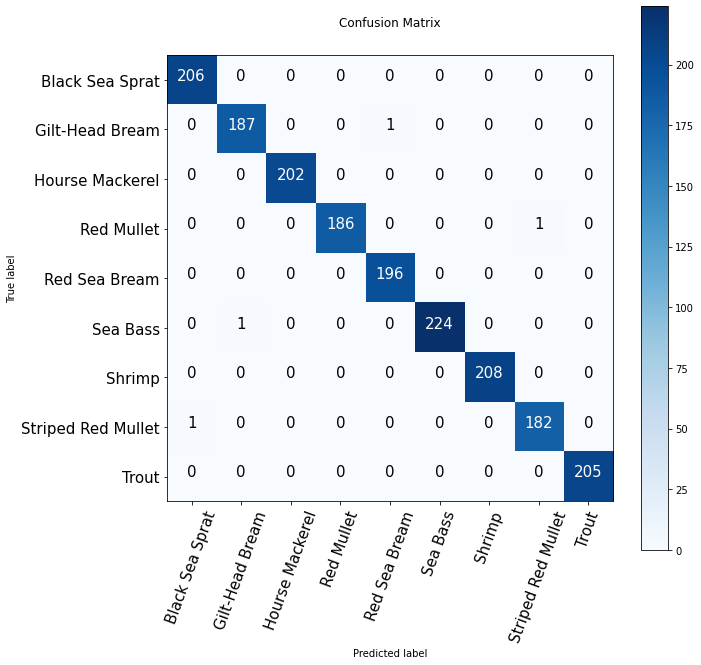

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

## Example Predictions

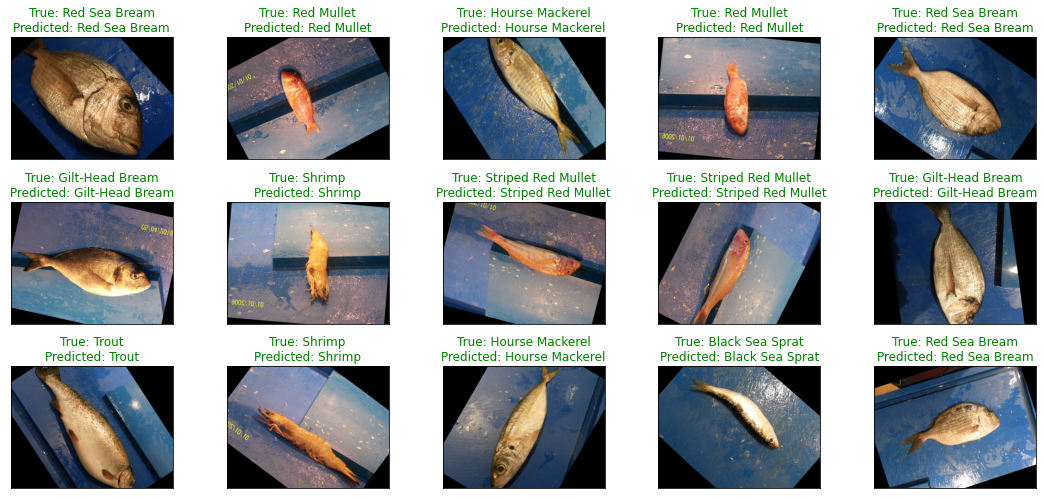

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.tight_layout()
plt.show()

## Predicting on our own image

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
filename= "/content/drive/MyDrive/Software Engineering 2/Test Images/shrimp.jpg"
image = load_and_prep_image(filename, scale=True)

In [ ]:
pred_prob = model.predict(tf.expand_dims(image, axis=0))
pred_prob

array([[1.5604314e-08, 2.8795650e-11, 7.1051875e-09, 1.0198042e-07,
        9.1148751e-09, 1.4131107e-08, 9.9999905e-01, 7.6272403e-07,
        9.2335355e-08]], dtype=float32)

In [ ]:
second = sorted(list(pred_prob[0]))[-3]
sec_index = (pred_prob == second).argmax()
second.max()

1.0198042e-07

In [ ]:
(pred_prob == second).argmax()

3

In [ ]:
classes = list(labels.values())
classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [ ]:
pred_class = classes[pred_prob.argmax()]
print(pred_class)

Shrimp


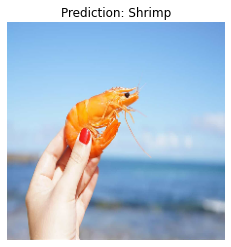

In [ ]:
pred_and_plot(model, filename, list(labels.values()))

In [ ]:
pred_prob.max()

0.99999905

## Save Model

In [ ]:
# model.save("fish_classification.h5")

## Grad-CAM class activation visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

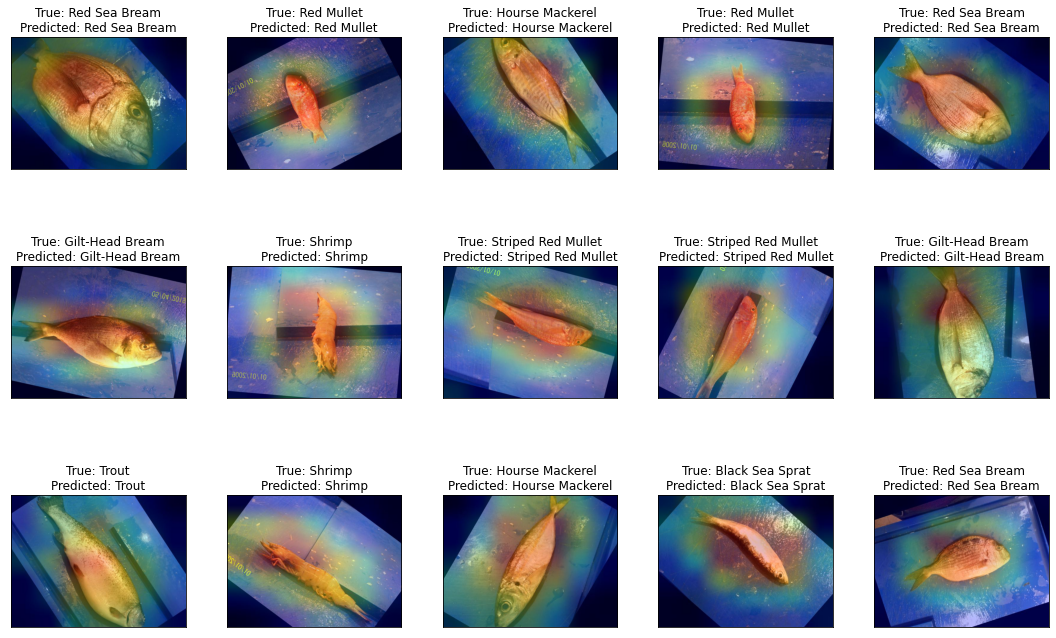

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()